In [1]:
%matplotlib inline
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from HDF5DatasetWriter import HDF5DatasetWriter
from HDF5DatasetGenerator import HDF5DatasetGenerator
from utils import *
from tqdm import tqdm
import cv2
from skimage import io
import SimpleITK as sitk

Using TensorFlow backend.


# 目标：

- 使用SimpleITK读取，形状还是【N张，宽， 高】
- 完成图像预处理

In [2]:
i = 2
data_path = './train/train/' + str(i+1000) + '/arterial phase'
image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path) if '.dcm' in s ]
image_slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)#-------实验证明！逆序的！

F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\pydicom\filereader.py:399: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


In [126]:
intercept =image_slices[0].RescaleIntercept
slope = image_slices[0].RescaleSlope
print('intercept', intercept)
print('slope', slope)

intercept -1024
slope 1


In [127]:
#验证是否从20到1，逆序
print(pydicom.dcmread(data_path + '/10001.dcm').InstanceNumber)
print(pydicom.dcmread(data_path + '/10002.dcm').InstanceNumber)
#说明原先是正序
print('=========================================')

for i in range(20):
    print(image_slices[i].InstanceNumber)
#说明现在是逆序

51
52
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51


In [128]:
print(len(image_slices))

20


In [129]:
#如果使用下面的语句会报错
#image_slices[0].pixel_array.shape
#换个方法
def loadFile(filename):
    ds = sitk.ReadImage(filename)
    img_array = sitk.GetArrayFromImage(ds)
    #frame_num, width, height = img_array.shape
    return img_array 

def get_pixels_hu_by_simpleitk(dicom_dir):

    #读取某文件夹内的所有dicom文件,并提取像素值(-4000 ~ 4000)

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    img_array = sitk.GetArrayFromImage(image)
    img_array[img_array == -2000] = 0
    return img_array

i = 1
data_path = './train/train/' + str(i+1000) + '/arterial phase'
image = get_pixels_hu_by_simpleitk(data_path)

In [130]:
#所以输入的image_slices，形状为（129,512,512）
image.shape

(20, 512, 512)

In [131]:
#打印下dicom_name看看,到时候也按照这个顺序添加label~
i = 1
data_path = './train/train/' + str(i+1000) + '/arterial phase'

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(data_path)
#print(list(dicom_names))
dicom_names = [s[:-4]+'_mask.png' for s in dicom_names ]

del reader
print(dicom_names)
livers = np.array([plt.imread(s) for s in dicom_names])
del dicom_names
print(livers.shape)

['./train/train/1001/arterial phase/10020_mask.png', './train/train/1001/arterial phase/10019_mask.png', './train/train/1001/arterial phase/10018_mask.png', './train/train/1001/arterial phase/10017_mask.png', './train/train/1001/arterial phase/10016_mask.png', './train/train/1001/arterial phase/10015_mask.png', './train/train/1001/arterial phase/10014_mask.png', './train/train/1001/arterial phase/10013_mask.png', './train/train/1001/arterial phase/10012_mask.png', './train/train/1001/arterial phase/10011_mask.png', './train/train/1001/arterial phase/10010_mask.png', './train/train/1001/arterial phase/10009_mask.png', './train/train/1001/arterial phase/10008_mask.png', './train/train/1001/arterial phase/10007_mask.png', './train/train/1001/arterial phase/10006_mask.png', './train/train/1001/arterial phase/10005_mask.png', './train/train/1001/arterial phase/10004_mask.png', './train/train/1001/arterial phase/10003_mask.png', './train/train/1001/arterial phase/10002_mask.png', './train/tr

In [132]:
def get_livers(data_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(data_path)
    dicom_names = [s[:-4]+'_mask.png' for s in dicom_names ]
    livers = np.array([plt.imread(s) for s in dicom_names])
    return livers

livers = get_livers(data_path)
print(livers.shape)

(20, 512, 512)


#### 保留三个变量  image_slices， image， livers , 并且对应关系

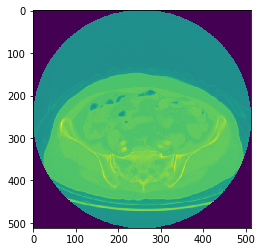

In [133]:
plt.imshow(image[19])
#应该是./train/train/1001/arterial phase/10001.dcm

(512, 512)


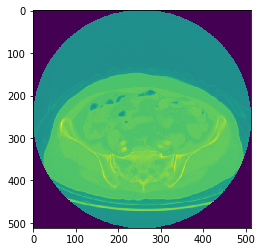

In [134]:
# 测试reader的Excute到底是不是逆序
image_1 = loadFile('./train/train/1001/arterial phase/10001.dcm')
print(np.array(image_1[0]).shape)
plt.imshow(np.squeeze(image_1[0]))

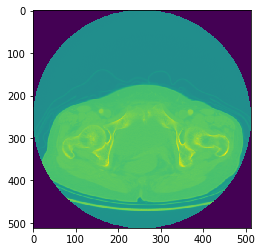

In [135]:
plt.imshow(image[0])
#应该是./train/train/1001/arterial phase/10020.dcm

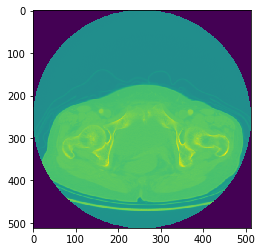

In [136]:
#真正的./train/train/1001/arterial phase/10020.dcm
image_20 = loadFile('./train/train/1001/arterial phase/10020.dcm')
np.array(image_20[0]).shape
plt.imshow(np.squeeze(image_20[0]))

In [137]:

# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
image = image.astype(np.int16)

# Set outside-of-scan pixels to 1
# The intercept is usually -1024, so air is approximately 0
image[image == -2000] = 0
    
# Convert to Hounsfield units (HU)
intercept = image_slices[0].RescaleIntercept
slope = image_slices[0].RescaleSlope
    
if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)
        
image += np.int16(intercept)

In [138]:
del image_slices
print(intercept)

-1024


In [139]:
image.shape

(20, 512, 512)

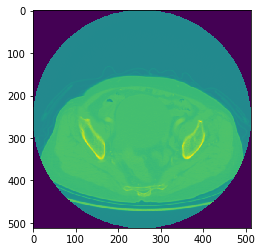

In [140]:
plt.imshow(image[10])

# windowing
<hr>
然而，hu的范围一般来说很大，这就导致了对比度很差，如果需要针对具体的器官进行处理，效果会不好，于是就有了windowing的方法：

In [419]:
def transform_ctdata(image, windowWidth, windowCenter, normal=False):
        """
        注意，这个函数的self.image一定得是float类型的，否则就无效！
        return: trucated image according to window center and window width
        """
        minWindow = float(windowCenter) - 0.5*float(windowWidth)
        newimg = (image - minWindow) / float(windowWidth)
        newimg[newimg < 0] = 0
        newimg[newimg > 1] = 1
        if not normal:
            newimg = (newimg * 255).astype('uint8')
        return newimg
    
images = transform_ctdata(image,3970,860)

In [420]:
#del image

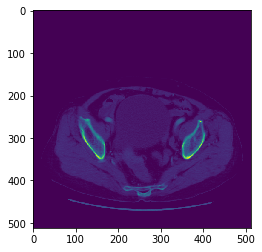

In [421]:
plt.imshow(images[10])

# getRangImageDepth
在训练网络时，一般目标区域越有针对性效果越好，因此经常会在训练前对数据进行预处理，提取出包含有目标的那些切片。

In [113]:
i = 1
label_path = './3Dircadb/3Dircadb1.%d/MASKS_DICOM/liver'%i
"""
args:
image ndarray of shape (depth, height, weight)
"""
def getRangImageDepth(image):
    """
    args:
    image ndarray of shape (depth, height, weight)
    """
    # 得到轴向上出现过目标（label>=1)的切片
    z = np.any(image, axis=(1,2)) # z.shape:(depth,)
    startposition,endposition = np.where(z)[0][[0,-1]]
    return startposition, endposition

start,end = getRangImageDepth(livers)

In [427]:
z = [0,0,0,1,2,3]
np.where(z)[0][[0,-1]]

array([3, 5], dtype=int64)

# 直方图均衡化

函数clahe_equalized

它是一种局部局部来的均衡化，也就是是说把整个图像分成许多小块（比如按10*10作为一个小块），那么对每个小块进行均衡化。这种方法主要对于图像直方图不是那么单一的（比如存在多峰情况）图像比较实用。Opencv中将这种方法称之为CLAHE，使用到的函数就是cv2.createCLAHE()，一个实例如下：


In [115]:
assert (len(images.shape)==3)  #3D arrays
#create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
imgs_equalized = np.empty(images.shape)
for i in range(start,end+1):
    imgs_equalized[i,:,:] = clahe.apply(np.array(images[i,:,:], dtype = np.uint8))


In [116]:
np.where(images[11])

(array([153, 153, 153, ..., 471, 471, 471], dtype=int64),
 array([222, 223, 224, ..., 289, 290, 291], dtype=int64))

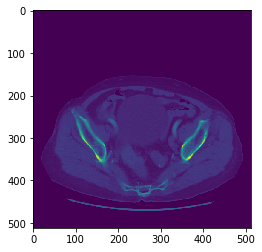

In [117]:
plt.imshow(images[11])

In [118]:
imgs_equalized[11][153][224]

7.0

In [119]:
print(livers[0][0][0])
livers[11][153][224]

0.0


0.0

In [120]:
del livers

In [121]:
np.where(imgs_equalized[11])

(array([  0,   0,   0, ..., 511, 511, 511], dtype=int64),
 array([  0,   1,   2, ..., 509, 510, 511], dtype=int64))

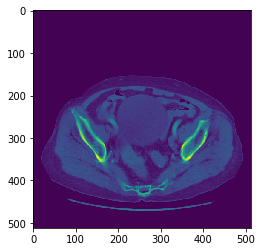

In [122]:
plt.imshow(imgs_equalized[11])

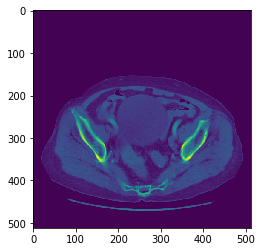

In [124]:
imgs_equalized /= 255
plt.imshow(imgs_equalized[11])

In [110]:
imgs_equalized[50][195][160]

0.5607843137254902

In [29]:
print('imgs_equalized',imgs_equalized.shape)
full_images = []
full_images.append(imgs_equalized)

full_images = np.vstack(full_images)
full_images = np.expand_dims(full_images,axis=-1)
print('full_images',full_images.shape)

imgs_equalized (129, 512, 512)
full_images (129, 512, 512, 1)


In [30]:
seed=1
image_datagen = ImageDataGenerator()
image_datagen.fit(full_images, augment=True, seed=seed)
image_generator = image_datagen.flow(full_images,seed=seed)

In [33]:
x = []
i = 0

x.append(image_generator.next())
x.append(image_generator.next())
x.append(image_generator.next())

x = np.vstack(x)
print(x.shape)

(65, 512, 512, 1)


# 计算train图片数目

In [57]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from HDF5DatasetWriter import HDF5DatasetWriter
from HDF5DatasetGenerator import HDF5DatasetGenerator
from utils import *
from tqdm import tqdm
import cv2
import SimpleITK as sitk

def getRangImageDepth(image):
    """
    args:
    image ndarray of shape (depth, height, weight)
    """
    # 得到轴向上出现过目标（label>=1)的切片
    z = np.any(image, axis=(1,2)) # z.shape:(depth,)
    startposition,endposition = np.where(z)[0][[0,-1]]
    return startposition, endposition

def get_livers(data_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(data_path)
    dicom_names = [s[:-4]+'_mask.png' for s in dicom_names ]
    livers = np.array([plt.imread(s) for s in dicom_names])
    return livers

sum_tumor = 0
#part1
for i in range(1,108): 
    if i == 16:
        continue
    data_path = './train/train/' + str(i+1000) + '/arterial phase'

    livers = get_livers(data_path)
#================================================
    """ 省略进行的预处理操作，具体见part2"""
    #part2
    # 接part1

   
    start,end = getRangImageDepth(livers)
   
    # 仅提取腹部所有切片中包含了肝脏的那些切片，其余的不要
  
    total = (end ) - (start) +1
    print("%d person, total slices %d"%(i,total))
    sum_tumor += total
print(sum_tumor)


1 person, total slices 6
2 person, total slices 6
3 person, total slices 3
4 person, total slices 12
5 person, total slices 6
6 person, total slices 8
7 person, total slices 8
8 person, total slices 10
9 person, total slices 10
10 person, total slices 4
11 person, total slices 8
12 person, total slices 9
13 person, total slices 7
14 person, total slices 5
15 person, total slices 8
17 person, total slices 8
18 person, total slices 7
19 person, total slices 10
20 person, total slices 5
21 person, total slices 14
22 person, total slices 11
23 person, total slices 5
24 person, total slices 5
25 person, total slices 11
26 person, total slices 5
27 person, total slices 7
28 person, total slices 7
29 person, total slices 8
30 person, total slices 14
31 person, total slices 13
32 person, total slices 11
33 person, total slices 12
34 person, total slices 8
35 person, total slices 10
36 person, total slices 5
37 person, total slices 5
38 person, total slices 7
39 person, total slices 5
40 person